## Librerías y funciones

Lo primero es cargar las librerías y funciones genéricas necesarias.

In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata
import string
from collections import Counter
import nltk
nltk.download('wordnet')

seed = 17

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display_html
from itertools import chain,cycle

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas
import random

from nltk import ngrams
from nltk.probability import FreqDist

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_recall_curve,make_scorer, recall_score, accuracy_score, precision_score

from wordcloud import WordCloud, STOPWORDS

import gzip
import pickle

[nltk_data] Downloading package wordnet to /Users/aaron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Carga de datos

En esta sección comprobaremos la estructura del data frame (DF) y seleccionaremos aquellas variables que nos interesen para el estudio.

In [2]:
# datos sin procesar
df = pd.read_csv('data/labeled_data.csv')
# drop duplicated index column
df.drop('Unnamed: 0', axis = 1, inplace = True)

# datos procesados
df_prep = pd.read_csv('data/labeled_data_preprocessed.csv')

In [3]:
df.head(5)

count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [4]:
df_prep.head(5)

Unnamed: 0                                              tweet  class  \
0           0  RT @CapitalT____: How you put ya hoes before y...      1   
1           1  RT @PriyaOhol: In Hopes of Recruiting More Wom...      2   
2           2  @Yankees @marines1994 Daggone it Twins, kick i...      2   
3           3  @LeonCountryBwoy your a big yute to be having ...      2   
4           4  RT @carterreynolds: Austin Mahone is making bi...      1   

                                        prepro_tweet  \
0  RT : How you put ya hoes before ya girlfriend ...   
1  RT : In Hopes of Recruiting More Women, ISIS O...   
2    Daggone it Twins, kick it up a notch... Time...   
3   your a big yute to be having slits in your br...   
4  RT : Austin Mahone is making bitches horny rig...   

                                          norm_tweet  
0            how you put ya hoe before ya girlfriend  
1  in hope of recruiting more woman isi open jiha...  
2  daggone it twin kick it up a notch time to bea...  
3  your a big yute to be having slit in your brow...  
4      austin mahone is making bitch horny right now

### Trabajamos únicamente con el texto y sentimiento de cada tweet

In [5]:
df = df[['tweet', 'class']]
df.head(5)

tweet  class
0  !!! RT @mayasolovely: As a woman you shouldn't...      2
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1

In [6]:
df_prep = df_prep[['norm_tweet', 'class']]
# renombramos
df_prep = df_prep.rename(columns = {'norm_tweet': 'tweet'})
df_prep.head(5)

tweet  class
0            how you put ya hoe before ya girlfriend      1
1  in hope of recruiting more woman isi open jiha...      2
2  daggone it twin kick it up a notch time to bea...      2
3  your a big yute to be having slit in your brow...      2
4      austin mahone is making bitch horny right now      1

In [7]:
df['tweet'] = df['tweet'].astype(str)
df_prep['tweet'] = df_prep['tweet'].astype(str)

## 2. Análisis exploratorio de los tweets

### 2.2. Longitud

Realizamos una comparativa del tamaño de los tweets.

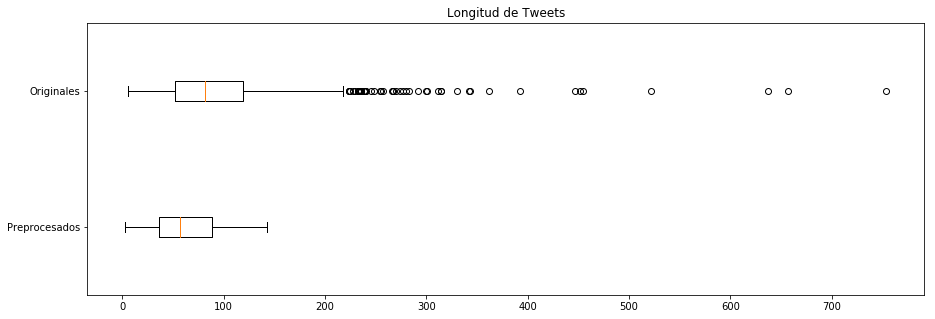

In [8]:
plt.figure(figsize = (15, 5))
plt.boxplot([[len(text) for text in df_prep['tweet']],
            [len(text) for text in df['tweet']]
            ],
    vert = False)
plt.yticks([1,2], ['Preprocesados', 'Originales'])
plt.title('Longitud de Tweets')
plt.show()

Después del preprocesado, los tweets han pasado a tener una menor longitud media, de unos 60 caracteres. Hay mucha menos dispersión en el número de caracteres y además todos los tweets tienen una longitud permitida por la plataforma.

### 2.3. Vocabulario (palabras, bigramas y trigramas)

Visualizamos el vocabulario que conforma el corpus a nivel de palabras, bigramas y trigramas.

In [9]:
# función para el cálculo de palabras, bigramas y trigramas
def get_vocabulary(df, col_name):
    
    words_ = []
    bigrams_ = []
    trigrams_ = []
    
    # iteramos para cada tweet y cada palabra
    for tweet in df[col_name]:
        for word in tweet.split():
            words_.append(word)
    
    # generamos bigramas y trigramas
    bigrams_ = list(ngrams(words_, 2))
    trigrams_ = list(ngrams(words_, 3))
    
    # diccionario con las tres categorías
    vocab = {
        'words': words_,
        'bigrams': bigrams_,
        'trigrams': trigrams_
    }
    
    return vocab

In [10]:
# aplicamos get_vocabulary a cada corpus
twitter_vocabulary = get_vocabulary(df, 'tweet')
twitter_vocabulary_prep = get_vocabulary(df_prep, 'tweet')

In [11]:
# función para representar "side by side"
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

A continuación vemos 6 tablas, con el top 20 de palabras, bigramas y trigramas con los datos originales y preprocesados respectivamente.

In [12]:
# top 20 palabras
wf = Counter(twitter_vocabulary['words'])
wf_most_common = wf.most_common(20)

# top 20 bigramas
bg_freq = Counter(twitter_vocabulary['bigrams'])
bg_freq_most_common = bg_freq.most_common(20)

# top 20 trigramas
tg_freq = Counter(twitter_vocabulary['trigrams'])
tg_freq_most_common = tg_freq.most_common(20)

# data frames
df_w = pd.DataFrame(wf_most_common, columns = ['palabra', 'total'])
df_b = pd.DataFrame(bg_freq_most_common, columns = ['bigrama', 'total'])
df_t = pd.DataFrame(tg_freq_most_common, columns = ['trigrama', 'total'])

# top 20 palabras datos preprocesados
wf_prep = Counter(twitter_vocabulary_prep['words'])
wf_most_common_prep = wf_prep.most_common(20)

# top 20 bigramas datos preprocesados
bg_freq_prep = Counter(twitter_vocabulary_prep['bigrams'])
bg_freq_most_common_prep = bg_freq_prep.most_common(20)

# top 20 trigramas datos preprocesados
tg_freq_prep = Counter(twitter_vocabulary_prep['trigrams'])
tg_freq_most_common_prep = tg_freq_prep.most_common(20)

# data frames datos preprocesados
df_w_prep = pd.DataFrame(wf_most_common_prep, columns = ['palabra', 'total'])
df_b_prep = pd.DataFrame(bg_freq_most_common_prep, columns = ['bigrama', 'total'])
df_t_prep = pd.DataFrame(tg_freq_most_common_prep, columns = ['trigrama', 'total'])

display_side_by_side(df_w, df_w_prep, df_b, df_b_prep, df_t, df_t_prep)

palabra 
 total 
 
 
 
 
 0 
 a 
 9099 
 
 
 1 
 RT 
 7539 
 
 
 2 
 bitch 
 6638 
 
 
 3 
 the 
 6590 
 
 
 4 
 I 
 6472 
 
 
 5 
 to 
 5240 
 
 
 6 
 you 
 4881 
 
 
 7 
 and 
 3670 
 
 
 8 
 that 
 3111 
 
 
 9 
 my 
 3072 
 
 
 10 
 in 
 2902 
 
 
 11 
 is 
 2759 
 
 
 12 
 bitches 
 2576 
 
 
 13 
 like 
 2534 
 
 
 14 
 of 
 2503 
 
 
 15 
 on 
 2361 
 
 
 16 
 be 
 2304 
 
 
 17 
 me 
 2249 
 
 
 18 
 for 
 2023 
 
 
 19 
 hoes 
 1925 
 
 
 
 
 
 
 palabra 
 total 
 
 
 
 
 0 
 bitch 
 8649 
 
 
 1 
 a 
 7747 
 
 
 2 
 i 
 5805 
 
 
 3 
 the 
 5469 
 
 
 4 
 you 
 4714 
 
 
 5 
 to 
 4062 
 
 
 6 
 hoe 
 3367 
 
 
 7 
 and 
 3024 
 
 
 8 
 my 
 2713 
 
 
 9 
 that 
 2708 
 
 
 10 
 in 
 2329 
 
 
 11 
 is 
 2225 
 
 
 12 
 like 
 2152 
 
 
 13 
 me 
 2065 
 
 
 14 
 of 
 1961 
 
 
 15 
 on 
 1903 
 
 
 16 
 be 
 1821 
 
 
 17 
 it 
 1716 
 
 
 18 
 pussy 
 1700 
 
 
 19 
 this 
 1692 
 
 
 
 
 
 
 bigrama 
 total 
 
 
 
 
 0 
 (a, bitch) 
 1090 
 
 
 1 
 (in, the) 
 657 
 
 
 2 
 (like, a) 
 486 
 
 
 3 
 (a, hoe) 
 434 
 
 
 4 
 (that, bitch) 
 408 
 
 
 5 
 (to, be) 
 384 
 
 
 6 
 (I, don't) 
 378 
 
 
 7 
 (is, a) 
 376 
 
 
 8 
 (this, bitch) 
 355 
 
 
 9 
 (these, hoes) 
 341 
 
 
 10 
 (on, the) 
 338 
 
 
 11 
 (be, a) 
 316 
 
 
 12 
 (of, the) 
 284 
 
 
 13 
 (for, the) 
 280 
 
 
 14 
 (I, got) 
 248 
 
 
 15 
 (I, was) 
 239 
 
 
 16 
 (to, the) 
 235 
 
 
 17 
 (I, hate) 
 235 
 
 
 18 
 (bitch, RT) 
 227 
 
 
 19 
 (on, my) 
 221 
 
 
 
 
 
 
 bigrama 
 total 
 
 
 
 
 0 
 (a, bitch) 
 1112 
 
 
 1 
 (in, the) 
 530 
 
 
 2 
 (a, hoe) 
 481 
 
 
 3 
 (bitch, i) 
 473 
 
 
 4 
 (this, bitch) 
 446 
 
 
 5 
 (that, bitch) 
 416 
 
 
 6 
 (these, hoe) 
 401 
 
 
 7 
 (like, a) 
 375 
 
 
 8 
 (if, you) 
 323 
 
 
 9 
 (i, don't) 
 303 
 
 
 10 
 (to, be) 
 294 
 
 
 11 
 (is, a) 
 293 
 
 
 12 
 (on, the) 
 281 
 
 
 13 
 (bitch, you) 
 266 
 
 
 14 
 (be, a) 
 250 
 
 
 15 
 (bad, bitch) 
 248 
 
 
 16 
 (you, a) 
 237 
 
 
 17 
 (i, got) 
 236 
 
 
 18 
 (i, hate) 
 231 
 
 
 19 
 (of, the) 
 223 
 
 
 
 
 
 
 trigrama 
 total 
 
 
 
 
 0 
 (a, bad, bitch) 
 86 
 
 
 1 
 (to, be, a) 
 78 
 
 
 2 
 (., ., .) 
 73 
 
 
 3 
 (look, like, a) 
 68 
 
 
 4 
 (like, a, bitch) 
 67 
 
 
 5 
 (I, hate, when) 
 61 
 
 
 6 
 (a, lot, of) 
 57 
 
 
 7 
 (a, bitch, that) 
 52 
 
 
 8 
 (is, a, bitch) 
 49 
 
 
 9 
 (in, this, bitch) 
 49 
 
 
 10 
 (a, little, bitch) 
 47 
 
 
 11 
 (be, a, bitch) 
 46 
 
 
 12 
 (a, bitch, RT) 
 45 
 
 
 13 
 (hoes, ain't, loyal) 
 43 
 
 
 14 
 (of, a, bitch) 
 40 
 
 
 15 
 (a, bitch, to) 
 40 
 
 
 16 
 (I, feel, like) 
 38 
 
 
 17 
 (son, of, a) 
 38 
 
 
 18 
 (in, the, pussy) 
 37 
 
 
 19 
 (bitch, ass, nigga) 
 35 
 
 
 
 
 
 
 trigrama 
 total 
 
 
 
 
 0 
 (a, bad, bitch) 
 86 
 
 
 1 
 (look, like, a) 
 72 
 
 
 2 
 (like, a, bitch) 
 65 
 
 
 3 
 (is, a, bitch) 
 62 
 
 
 4 
 (to, be, a) 
 60 
 
 
 5 
 (i, hate, when) 
 60 
 
 
 6 
 (a, lot, of) 
 58 
 
 
 7 
 (gt, gt, gt) 
 57 
 
 
 8 
 (a, little, bitch) 
 55 
 
 
 9 
 (these, hoe, ain't) 
 54 
 
 
 10 
 (in, this, bitch) 
 52 
 
 
 11 
 (you, a, hoe) 
 50 
 
 
 12 
 (be, a, bitch) 
 49 
 
 
 13 
 (bitch, as, nigga) 
 48 
 
 
 14 
 (hoe, ain't, loyal) 
 47 
 
 
 15 
 (a, bitch, that) 
 45 
 
 
 16 
 (a, bitch, i) 
 45 
 
 
 17 
 (bitch, in, the) 
 44 
 
 
 18 
 (the, fuck, up) 
 41 
 
 
 19 
 (of, a, bitch) 
 41

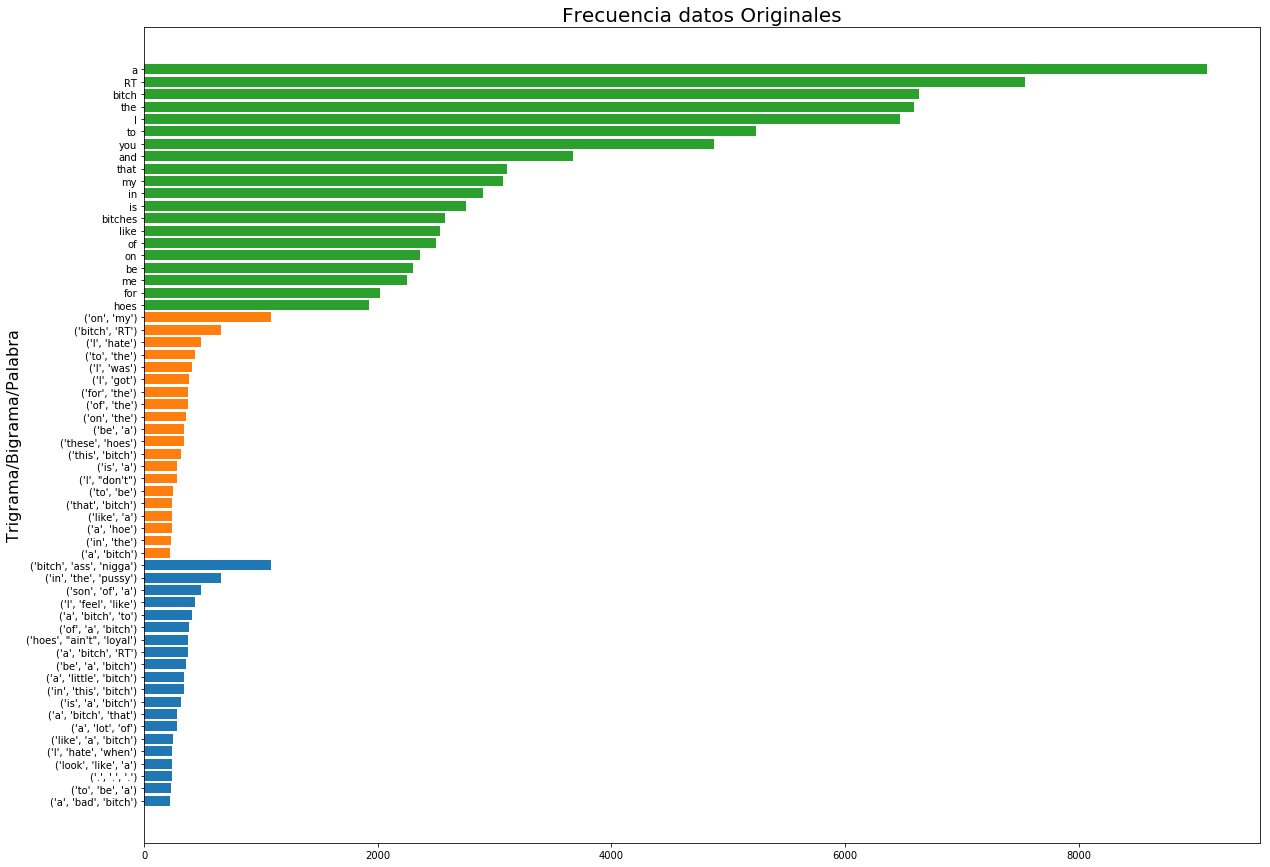

In [13]:
plt.rcParams['figure.figsize'] = (20, 15)

# palabras
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))

# bigramas
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))

# trigramas
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]
tgs_f_, bgs_ = zip(*sorted(zip(tgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

plt.barh(tgs_, bgs_f_)
plt.barh(bgs_, bgs_f_)
plt.barh(words, freqs)

plt.title('Frecuencia datos Originales', fontsize = 20)
plt.ylabel('Trigrama/Bigrama/Palabra', fontsize = 16)

# display the plot
plt.show()

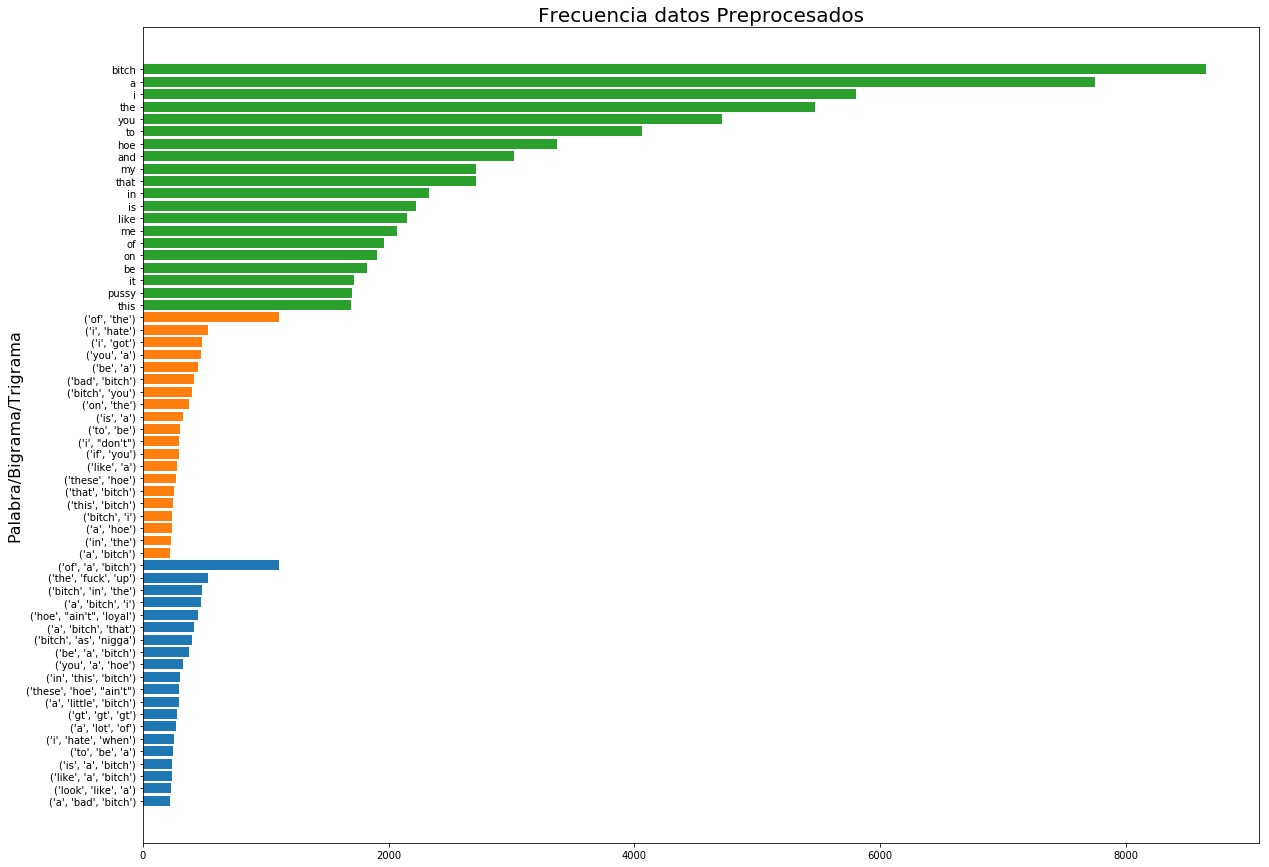

In [14]:
plt.rcParams['figure.figsize'] = (20, 15)

# palabras
words_prep = [w[0] for w in wf_most_common_prep]
freqs_prep = [w[1] for w in wf_most_common_prep]
freqs_prep, words_prep = zip(*sorted(zip(freqs_prep, words_prep)))

# bigramas
bgs__prep = [str(bg[0]) for bg in bg_freq_most_common_prep]
bgs_f__prep = [bg[1] for bg in bg_freq_most_common_prep]
bgs_f__prep, bgs__prep = zip(*sorted(zip(bgs_f__prep, bgs__prep)))

# trigramas
tgs__prep = [str(tg[0]) for tg in tg_freq_most_common_prep]
tgs_f__prep = [tg[1] for tg in tg_freq_most_common_prep]
tgs_f__prep, bgs__prep = zip(*sorted(zip(tgs_f__prep, bgs__prep)))
tgs_f__prep, tgs__prep = zip(*sorted(zip(tgs_f__prep, tgs__prep)))

plt.barh(tgs__prep, bgs_f__prep)
plt.barh(bgs__prep, bgs_f__prep)
plt.barh(words_prep, freqs_prep)

plt.title('Frecuencia datos Preprocesados', fontsize = 20)
plt.ylabel('Palabra/Bigrama/Trigrama', fontsize = 16)

# display the plot
plt.show()

Resumen: en las figuras se observa que, efectivamente, el top de palabras, bigramas y trigramas está compuesto por lenguaje ofensivo como insultos, palabras racistas y contenido despectivo.

### 2.4. Nube de palabras

El procesado implícito que se realiza al calcular la nube de palabras por clase de sentimiento, así como su representación jugando con el tamaño de la palabra en función de su frecuencia de aparición, permiten inferir, al menos a alto nivel, los sentimientos sobre las que se han calculado dichas nubes de palabras.

In [15]:
stopwords = set(STOPWORDS).add("RT")

# creamos las wordcloud de los datos sin preprocesar
# total
def random_color_func(word = None, font_size = None, position = None,  
                      orientation = None, font_path = None, random_state = None):
    h = 0
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
    background_color = 'black',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df)).recolor(color_func = random_color_func, random_state = 1)

# clase 0
def random_color_func(word = None, font_size = None, position = None,  
                      orientation = None, font_path = None, random_state = None):
    h = 300
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud0 = WordCloud(
    background_color = 'black',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df.loc[df['class'] == 0])).recolor(color_func = random_color_func, random_state = 1)

# clase 1
def random_color_func(word = None, font_size = None, position = None, 
                      orientation = None, font_path = None, random_state = None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud1 = WordCloud(
    background_color = 'black',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df.loc[df['class'] == 1])).recolor(color_func = random_color_func, random_state = 1)

# clase 2
def random_color_func(word = None, font_size = None, position = None, 
                      orientation = None, font_path = None, random_state = None):
    h = 200#180
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud2 = WordCloud(
    background_color = 'black',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df.loc[df['class'] == 2])).recolor(color_func = random_color_func, random_state = 1)

In [16]:
# creamos las wordcloud de los datos procesados
# total
def random_color_func(word = None, font_size = None, position = None,  
                      orientation = None, font_path = None, random_state = None):
    h = 0
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud_prep = WordCloud(
    background_color = 'black',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df_prep)).recolor(color_func = random_color_func, random_state = 1)

# clase 0
def random_color_func(word = None, font_size = None, position = None,  
                      orientation = None, font_path = None, random_state = None):
    h = 300#344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud0_prep = WordCloud(
    background_color = 'black',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df_prep.loc[df_prep['class'] == 0])).recolor(color_func = random_color_func, random_state = 1)

# clase 1
def random_color_func(word = None, font_size = None, position = None, 
                      orientation = None, font_path = None, random_state = None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud1_prep = WordCloud(
    background_color = 'black',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df_prep.loc[df_prep['class'] == 1])).recolor(color_func = random_color_func, random_state = 1)

# clase 2
def random_color_func(word = None, font_size = None, position = None, 
                      orientation = None, font_path = None, random_state = None):
    h = 200
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud2_prep = WordCloud(
    background_color = 'black',
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 60, 
    random_state = 42
).generate(str(df_prep.loc[df_prep['class'] == 2])).recolor(color_func = random_color_func, random_state = 1)

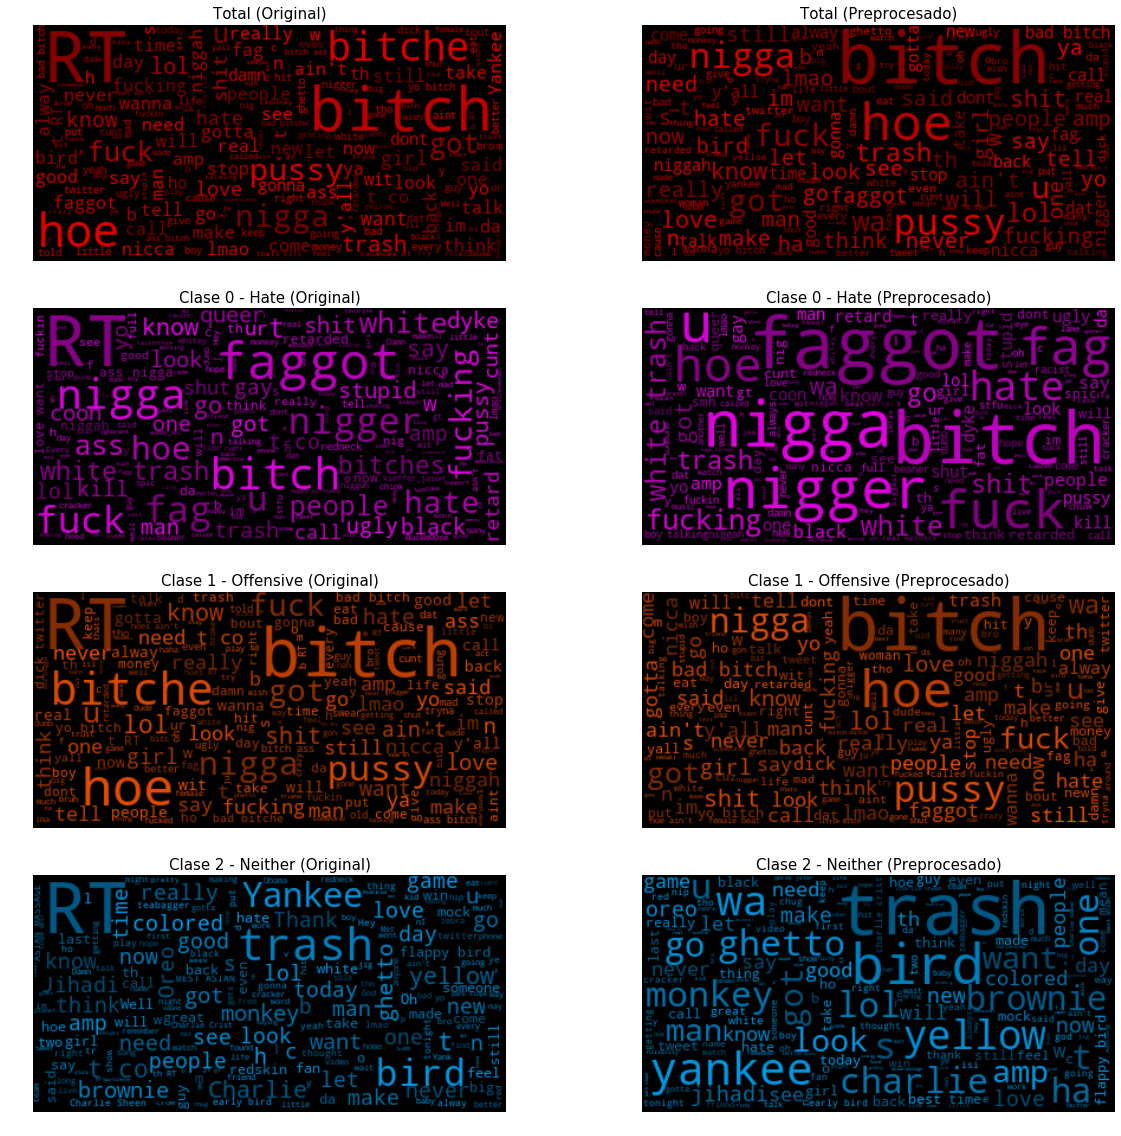

In [17]:
plt.figure(figsize = (20, 20))

# listas de wordclouds y sus nombres
wc = [wordcloud, wordcloud_prep, wordcloud0, wordcloud0_prep, wordcloud1, wordcloud1_prep, wordcloud2, wordcloud2_prep]
wc_n = ['Total (Original)', 'Total (Preprocesado)', 
        'Clase 0 - Hate (Original)', 'Clase 0 - Hate (Preprocesado)', 
        'Clase 1 - Offensive (Original)', 'Clase 1 - Offensive (Preprocesado)', 
        'Clase 2 - Neither (Original)', 'Clase 2 - Neither (Preprocesado)']

# representamos wordclouds
for i in range(0, 8):
    plt.subplot(4, 2, i+1)
    plt.imshow(wc[i], interpolation = 'bilinear')
    plt.axis('off')
    plt.title(wc_n[i], fontsize = 15)

Vemos que una vez que los datos son preprocesados, se hace más evidente el contenido ofensivo y de odio en las palabra más repetidas.